In [1]:
import torch
from torch import nn, tanh, relu
import h5py
import gc
from torch.utils.data import DataLoader
import time
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from torch.autograd import grad

In [2]:
rng = np.random.default_rng()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
sensors = 100
P = 250
u = np.linspace(-1, 1, sensors).reshape(1, -1).repeat(P, axis = 0)
u = u ** 2 * np.cos(np.pi * u)
u = torch.tensor(u, dtype = torch.double)

In [19]:
with h5py.File('../observations.hf', 'r') as f:
    batch_size = 250
    data = np.array(f['ob5'])
    rng.shuffle(data)
    index = int(0.1 * data.shape[0])
    train_xta = data[:index, :2]
    train_xta = DataLoader(train_xta, batch_size = batch_size, drop_last = True)
    train_s = data[:index, [4]]
    train_s = DataLoader(train_s, batch_size = batch_size, drop_last = True)
    data = None

In [20]:
for xta, s in zip(train_xta, train_s):
    print(u.shape, xta.shape, s.shape)
    break

torch.Size([250, 100]) torch.Size([250, 2]) torch.Size([250, 1])


In [21]:
class MyModel(nn.Module):
    def __init__(self, branch_depth, branch_width, trunk_depth, trunk_width, sensors, P):
        super(MyModel, self).__init__()
        self.epoch = 0
        self.train_losses = []
        self.log_losses = []
        self.durations = []
        self.trunk_layers = []
        self.branch_layers = []
        self.final_bias = nn.Parameter(torch.zeros(1, dtype = torch.double))
        self.sensors = sensors
        self.P = P
        func = nn.Tanh()

        for i in range(branch_depth - 1):
            if i == 0:
                in1, out1 = self.sensors, branch_width
            else:
                in1 = out1 = branch_width
            self.branch_layers.append(nn.Linear(in1, out1, dtype = torch.double))
            nn.init.xavier_uniform_(self.branch_layers[-1].weight)
            nn.init.zeros_(self.branch_layers[-1].bias)
            self.branch_layers.append(func)
        self.branch_layers.append(nn.Linear(branch_width, branch_width, dtype = torch.double))
        nn.init.xavier_uniform_(self.branch_layers[-1].weight)
        nn.init.zeros_(self.branch_layers[-1].bias)

        for i in range(trunk_depth):
            if i == 0:
                in2, out2 = 2, trunk_width
            else:
                in2 = out2 = trunk_width
            self.trunk_layers.append(nn.Linear(in2, out2, dtype = torch.double))
            nn.init.xavier_uniform_(self.trunk_layers[-1].weight)
            nn.init.zeros_(self.trunk_layers[-1].bias)
            self.trunk_layers.append(func)
        
        self.branch_net = nn.Sequential(*self.branch_layers)
        self.trunk_net = nn.Sequential(*self.trunk_layers)
            
    def forward(self, branch_inputs, trunk_inputs):
        branch_inputs = self.branch_net(branch_inputs)
        
        trunk_inputs = self.trunk_net(trunk_inputs)
        res = torch.einsum('bi,bi->b', branch_inputs, trunk_inputs).reshape(len(branch_inputs), 1) + self.final_bias
        return res
    
    def start_training(self, u, max_epoch, validate, make_plot, optimizer, scheduler):
        self.make_plot = make_plot
        loss_fn = nn.MSELoss()
        self.max_epoch = max_epoch
        self.validate = validate
        
        u = u.to(device)

        while (self.epoch < self.max_epoch):
            
            self.epoch += 1
            start = time.time()
            
            for xta, s in zip(train_xta, train_s):
                
                optimizer.zero_grad()

                xta = xta.to(device)
                s = s.to(device)
                s_hat = self(u, xta)

                l2_loss = loss_fn(s, s_hat)

                loss = l2_loss
                loss.backward()
                #torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)
                optimizer.step()

            scheduler.step()
            self.train_losses.append(loss.item())
            self.log_losses.append(torch.log10(loss).item())
        
            stop = time.time()
            duration = stop - start
            self.durations.append(duration)
            if self.epoch % 50 == 0:
                clear_output(wait = True)
                print(f"Train epoch: {self.epoch}, loss: {self.train_losses[-1]:.2e}, duration: {duration:.2e}")
            
            if self.make_plot and self.epoch % 50 == 0:
                g = plt.plot(self.log_losses, label = 'train')
                g = plt.legend()
                g = plt.xlabel('epoch')
                g = plt.ylabel('log-loss')
                g = plt.show()

In [22]:
model = MyModel(7, 100, 7, 100, sensors, P).to(device)

make_plot = True
max_epoch = 1000000
validate = False
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1000, gamma = 0.9)

In [40]:
try:
    make_plot = True
    model.start_training(u, max_epoch, validate, make_plot, optimizer, scheduler)
except KeyboardInterrupt:
    print("Training paused.")
gc.collect()

Train epoch: 23250, loss: 3.26e-05, duration: 3.48e-02
Training paused.


76900

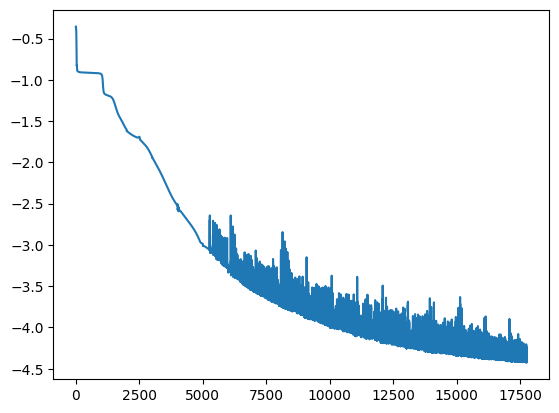

In [33]:
plt.plot(model.log_losses, label = 'train')

In [34]:
with h5py.File('../observations.hf', 'r') as file:
    test_data = np.array(file['ob5'])
    test_xta = test_data[:, :2]
    test_s = test_data[:, [4]]
    test_xta = torch.tensor(test_xta, dtype = torch.double)
    test_s = torch.tensor(test_s, dtype = torch.double)
    test_u = np.linspace(-1, 1, sensors).reshape(1, -1).repeat(10000, axis = 0)
    test_u = test_u ** 2 * np.cos(np.pi * test_u)
    test_u = torch.tensor(test_u, dtype = torch.double)
    print(test_u.shape, test_xta.shape, test_s.shape)
    a = test_data[0, [2, 3]]
    print(a)
    test_data = None

torch.Size([10000, 100]) torch.Size([10000, 2]) torch.Size([10000, 1])
[1.e-04 5.e+00]


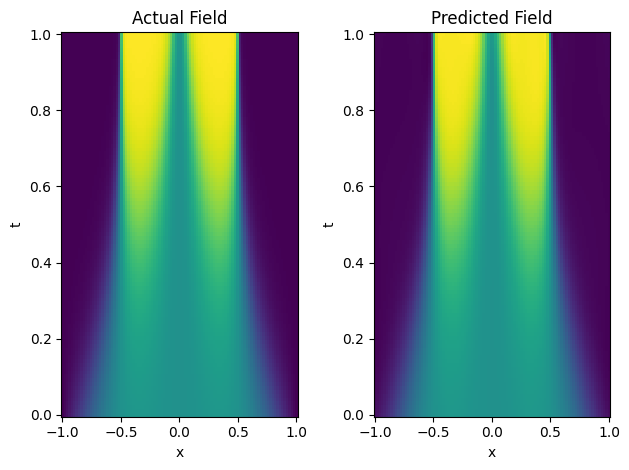

In [41]:
N = 100
x = test_xta[:, 0].reshape(N, N)
t = test_xta[:, 1].reshape(N, N)
g = plt.figure()
g = plt.subplot(1, 2, 1)
g = plt.pcolormesh(x, t, test_s.reshape(N, N))
g = plt.title('Actual Field')
g = plt.xlabel('x')
g = plt.ylabel('t')
g = plt.subplot(1, 2, 2)
with torch.no_grad():
    out = model(test_u.to(device), test_xta.to(device)).to('cpu')
g = plt.pcolormesh(x, t, out.reshape(N, N))
g = plt.title('Predicted Field')
g = plt.xlabel('x')
g = plt.ylabel('t')
g = plt.tight_layout()

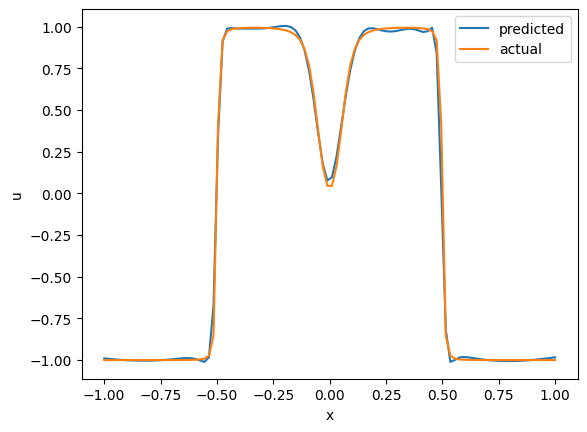

In [42]:
# Time slices between 1 and N
k = 100
g = plt.plot(test_xta[(k - 1) * N:k * N, 0], out[(k - 1) * N:k * N], label = 'predicted')
g = plt.plot(test_xta[(k - 1) * N:k * N, 0], test_s[(k - 1) * N:k * N], label = 'actual')
g = plt.xlabel('x')
g = plt.ylabel('u')
g = plt.legend()

In [17]:
torch.save({'weights': model.state_dict(), 'train_losses':model.train_losses, 'log_losses':model.log_losses,
            'epochs': model.epoch, 'a':a, 
            'durations': model.durations}, '../Trained Models/DeepONet_exp3.pt')